# Full reconstruction workflow pipeline
This is an example of a full reconstruction workflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymuhrec.utils.readers as io
import pymuhrec.utils.imageutils as amg

# import nitools.imgalg.muhrectomo as mt
import pymuhrec as pm
%config InlineBackend.figure_format = 'retina'

## Load data (The wood data)
The wood data is the data I use a lot for demos, tests, and tutorials. It a piece of petrified wood [DOI](http://dx.doi.org/10.17632/g5snr785xy.2). 

In [2]:
datapath = 'C:/Users/christianvedel/Imaging/NeutronImaging_test/wooddata/projections/'

In [3]:
ob = io.read_images(datapath+'ob_{0:04d}.tif',0,4,averageStack=True).mean(axis=0)
dc = io.read_images(datapath+'dc_{0:04d}.tif',0,4,averageStack=True).mean(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
proj = io.read_images(datapath+'wood_{0:04d}.tif',0,625) # This takes a while

  0%|          | 0/626 [00:00<?, ?it/s]

### Inspecting the data

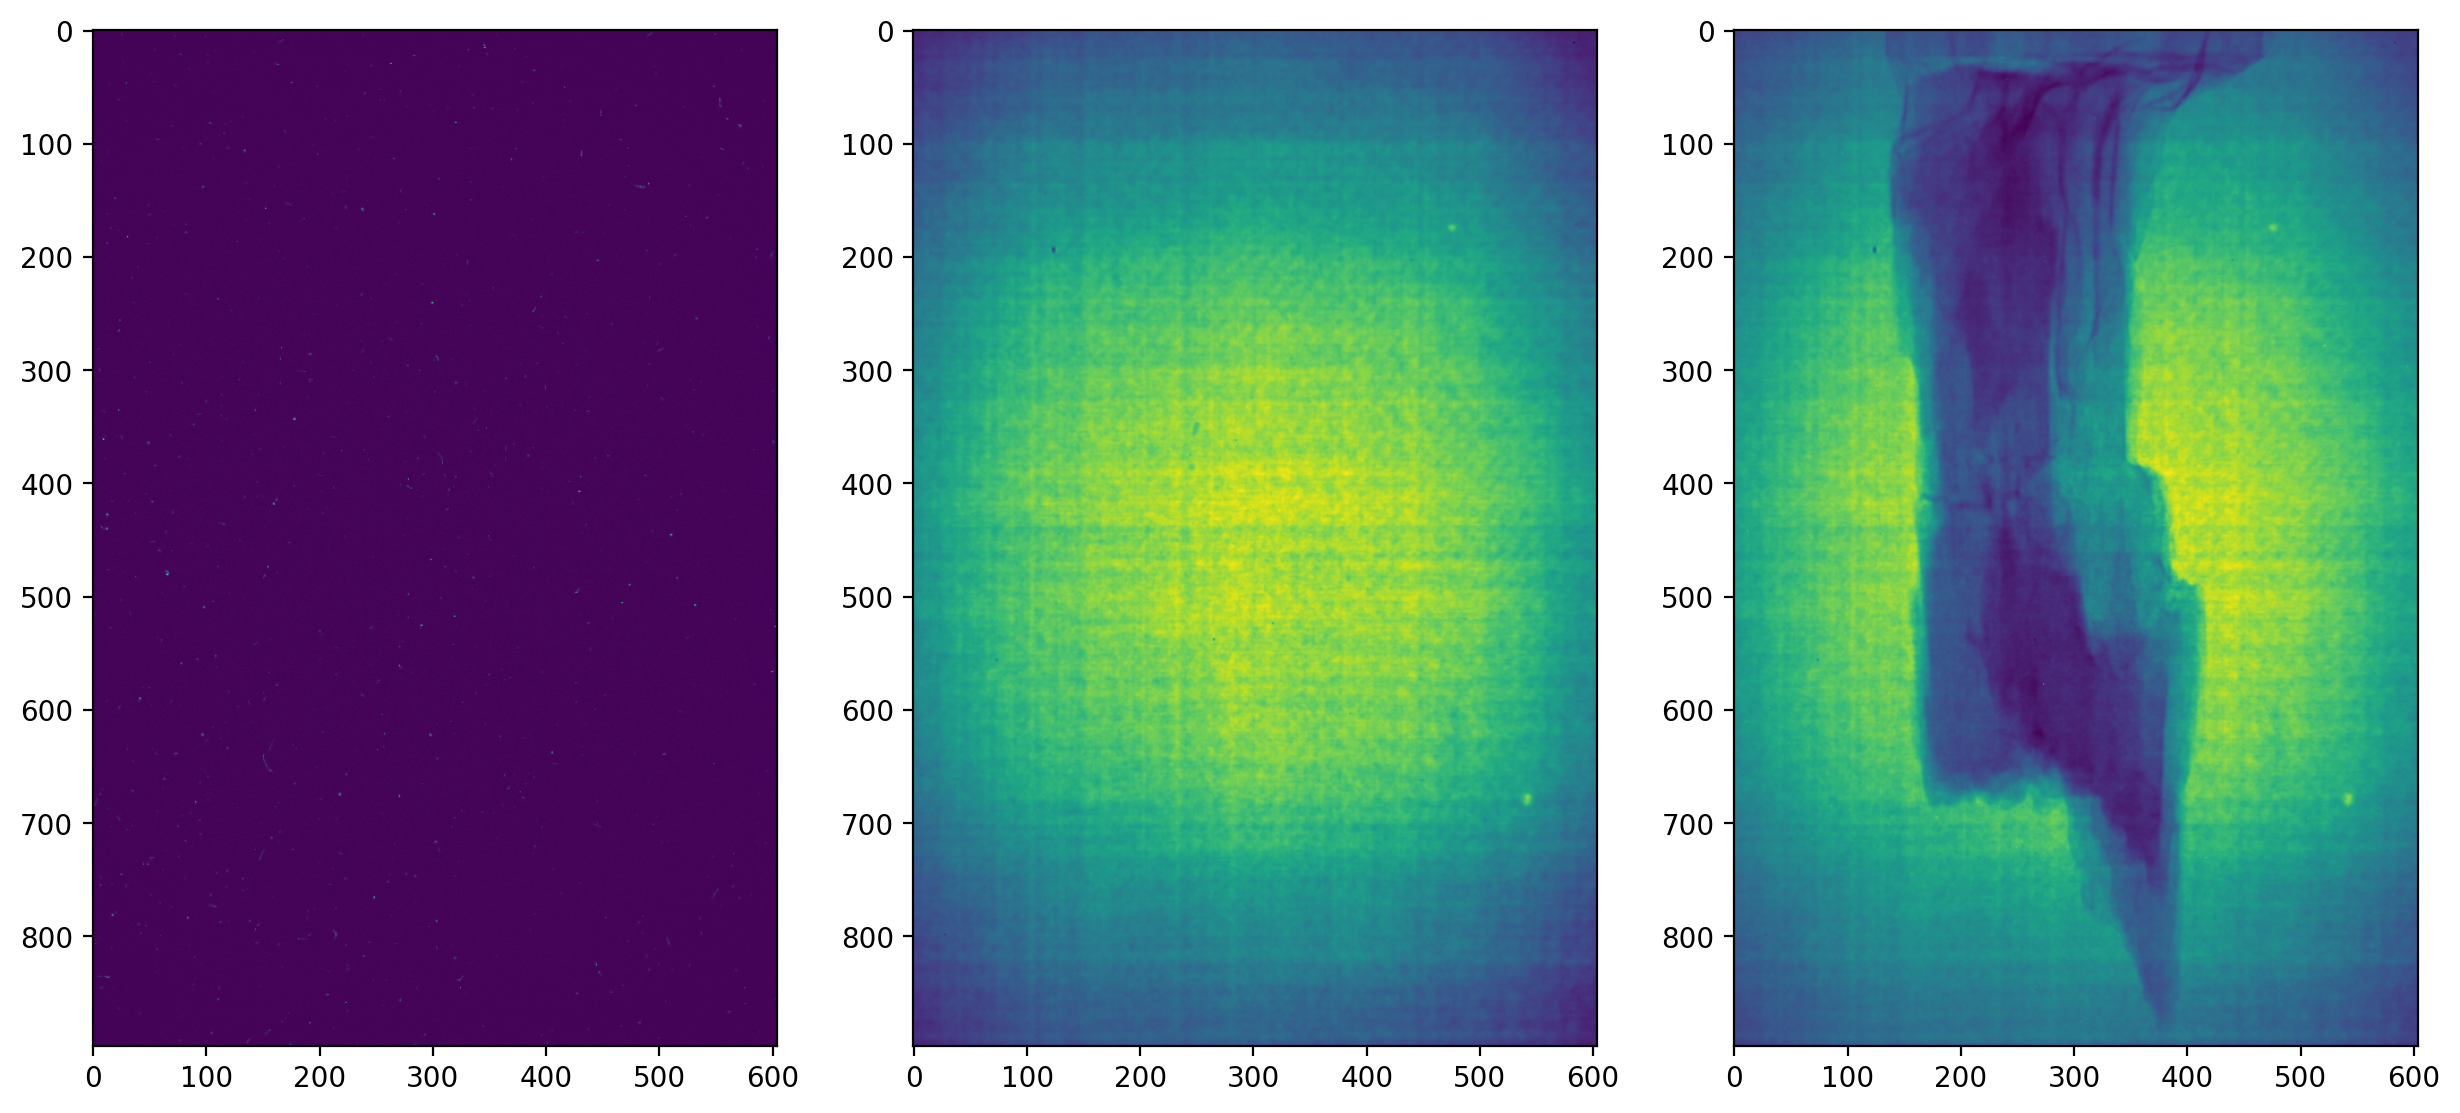

In [5]:
fig,ax = plt.subplots(1,3,figsize=[15,7])
ax[0].imshow(dc)
ax[1].imshow(ob)
ax[2].imshow(proj[0])

## Normalize 
Create a image normalization instance from the imaging algorithms package.



In [6]:
cproj = proj.copy()

In [7]:
norm = pm.NormalizeImage(True) # True for use logarithm
norm.setReferences(ob,dc)
norm.process(cproj)

### Vizualisation

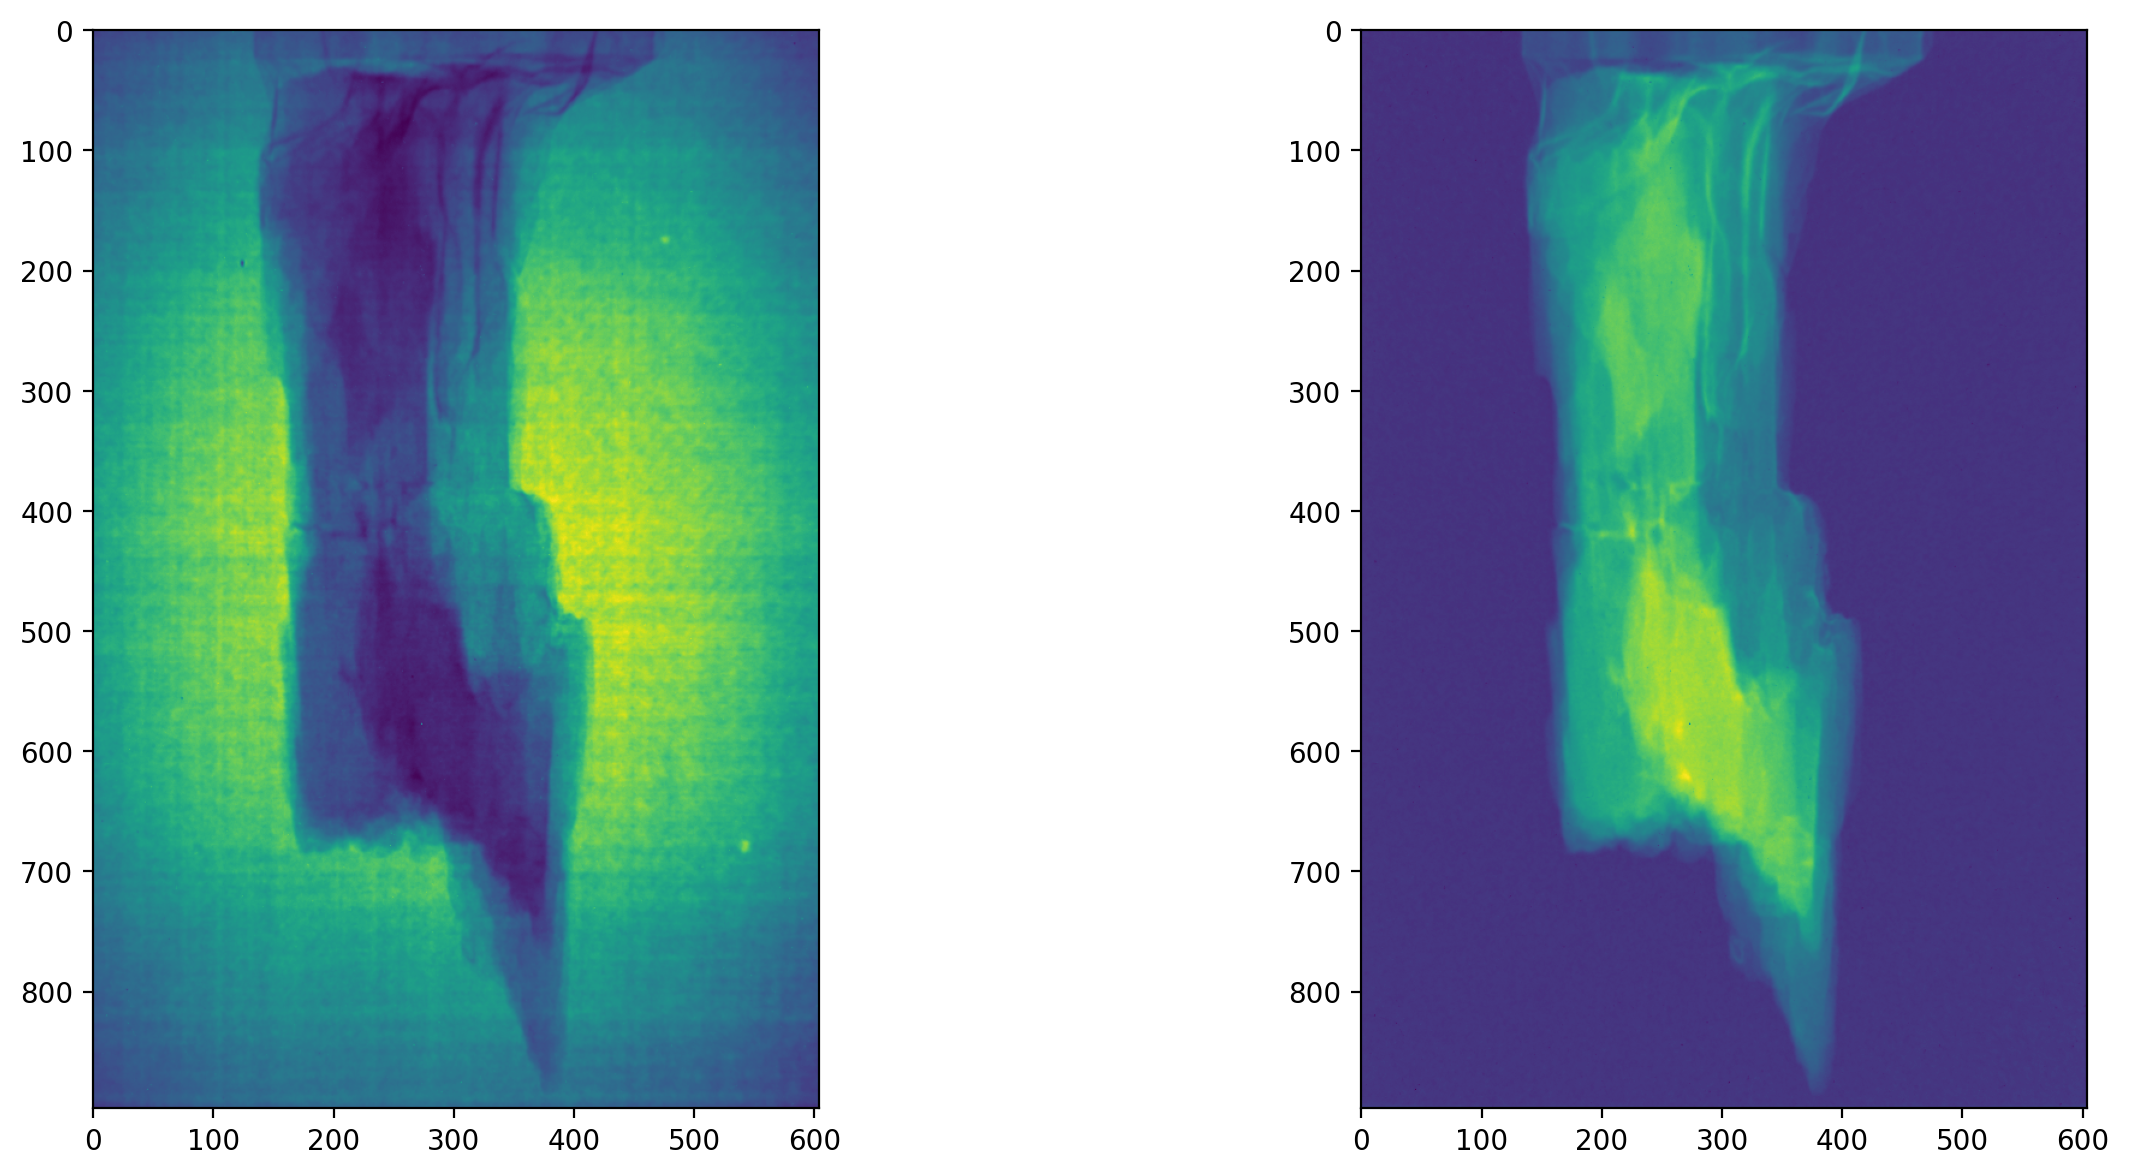

In [8]:
fig,ax = plt.subplots(1,2,figsize=[15,7])
ax[0].imshow(proj[0])
ax[1].imshow(cproj[0])

## Spot Cleaning

In [9]:
spot_cleaned_data = cproj.copy()

In [10]:
spotclean = pm.MorphSpotClean()
spotclean.setCleanMethod(detectionMethod=pm.MorphDetectAllSpots, cleanMethod=pm.MorphCleanReplace)
spotclean.process(spot_cleaned_data, th=[0.99, 0.99], sigma=[0.01, 0.01])

Process 3D: py::array_t<float> &x, std::vector<float> &th, std::vector<float> &sigma


### Visualization

Text(0.5, 1.0, 'm=-0.00018, s=0.00486')

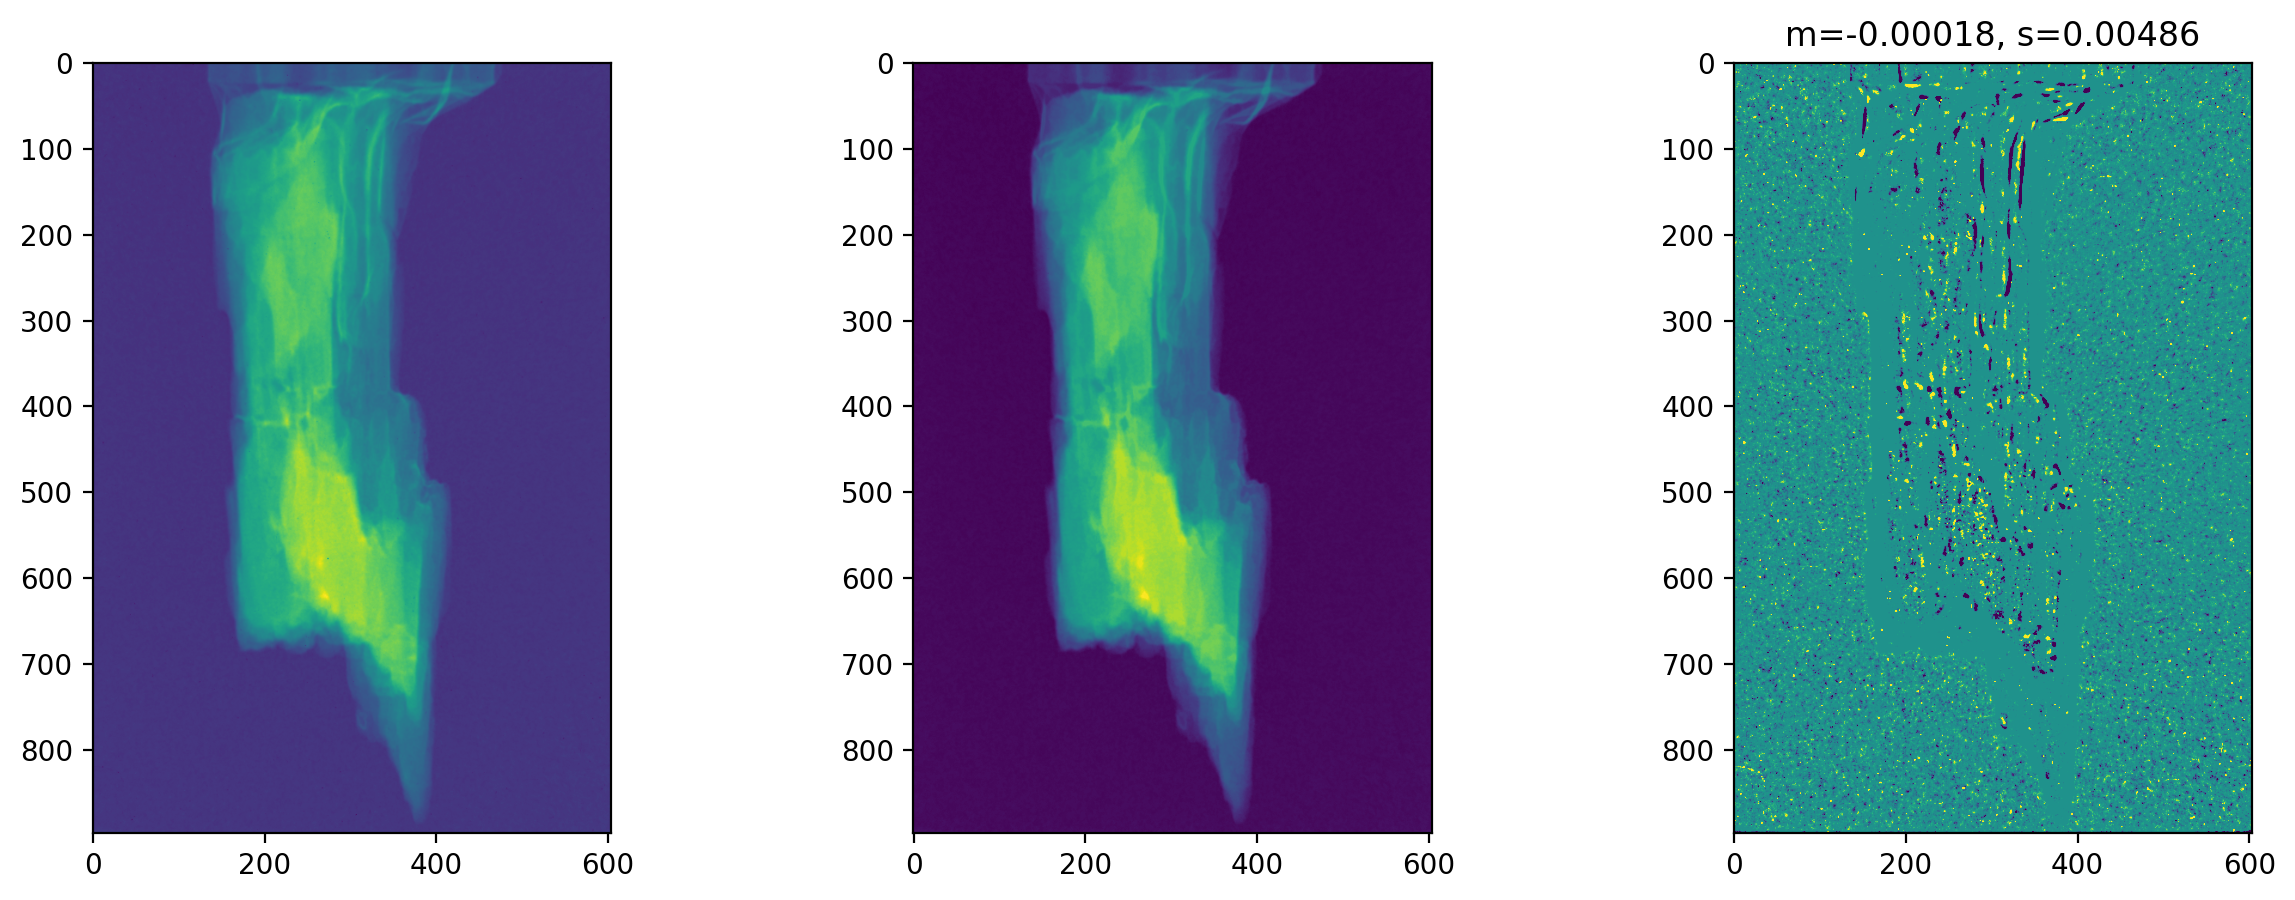

In [11]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
idx = 0
ax[0].imshow(cproj[idx])
ax[1].imshow(spot_cleaned_data[idx])
diff= spot_cleaned_data[idx]-cproj[idx]
m = diff.mean()
s = diff.std()
ax[2].imshow(spot_cleaned_data[idx]-cproj[idx],vmin=m-2*s,vmax=m+2*s);
ax[2].set_title("m={0:0.5f}, s={1:0.5f}".format(m,s))

## Ring Cleaning

In [12]:
ring_cleaned_data = spot_cleaned_data.copy()

In [13]:
ringclean = pm.StripeFilter([ring_cleaned_data.shape[2], ring_cleaned_data.shape[0]], "daub7", 4, 0.05)
ringclean.process(ring_cleaned_data, pm.eStripeFilterOperation.VerticalComponentFFT)

### Visualization

Text(0.5, 1.0, 'm=-0.00000, s=0.00989')

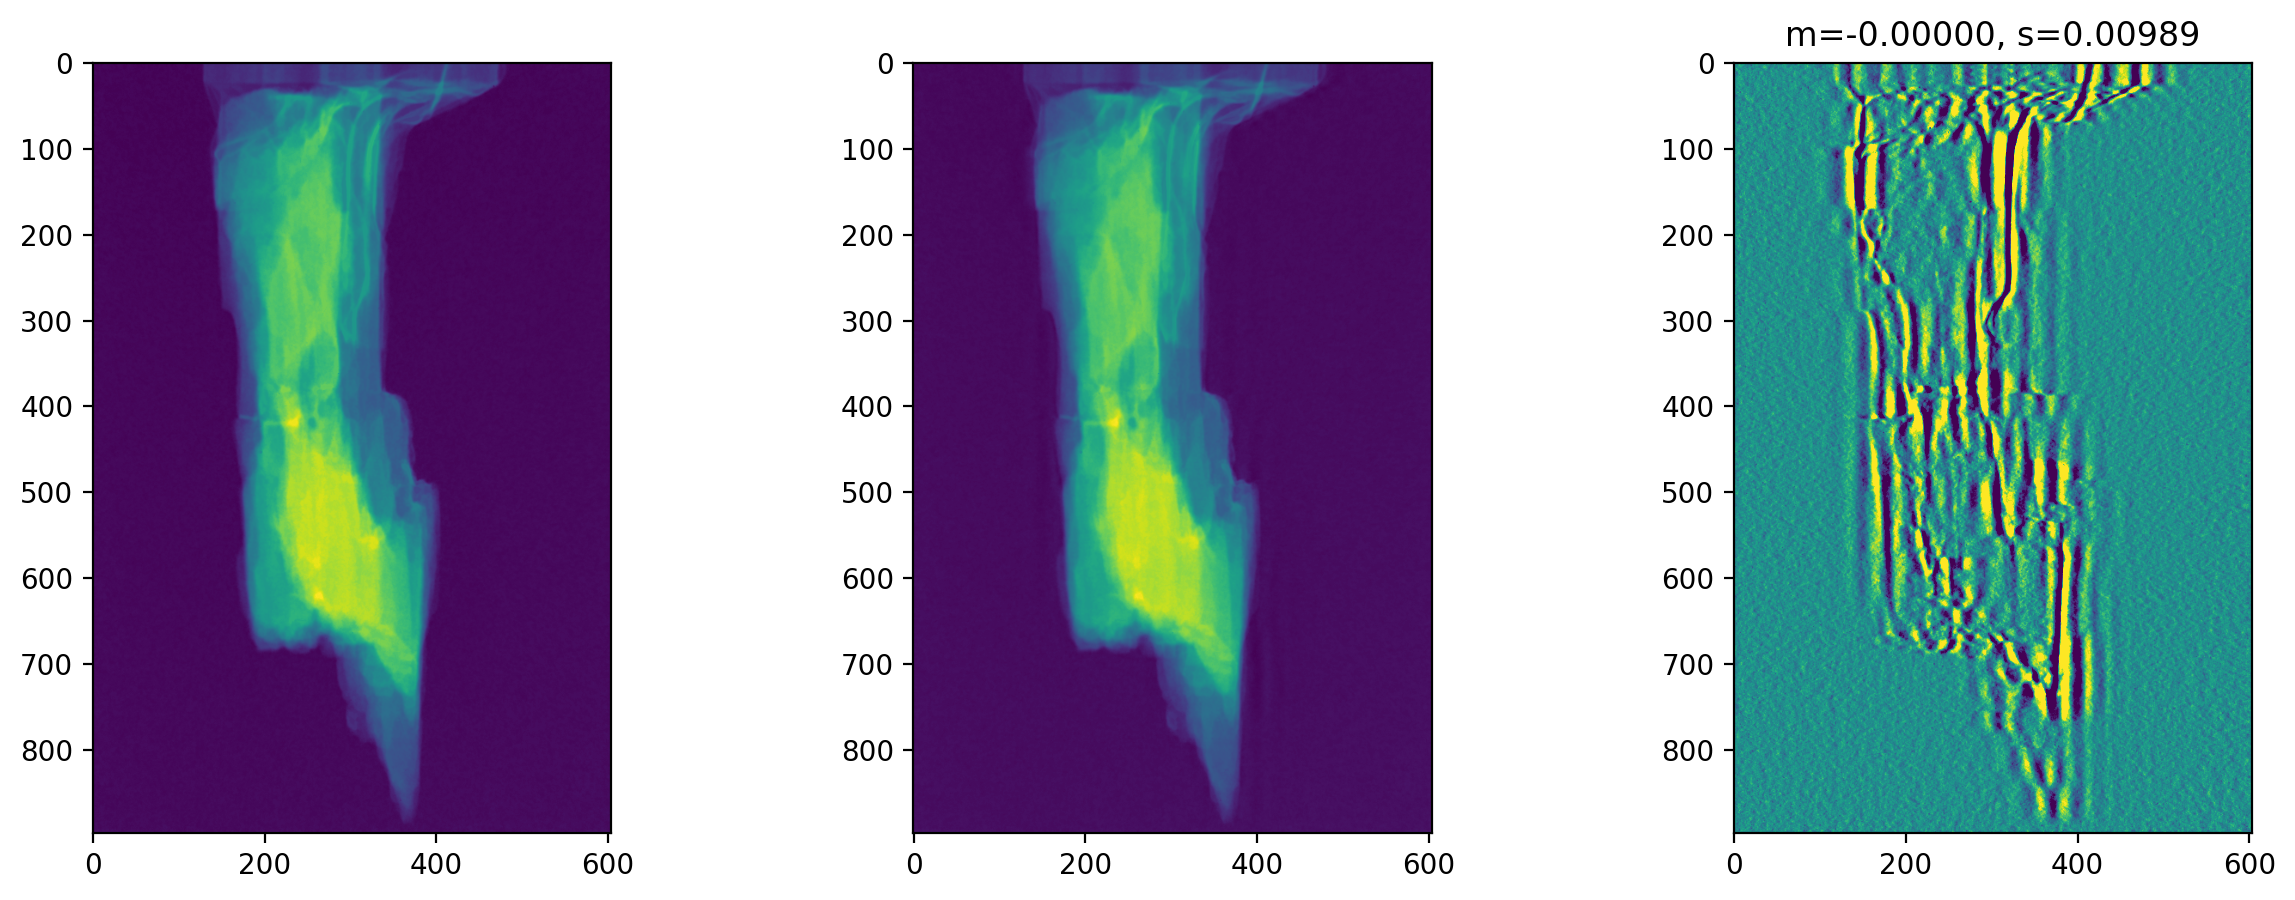

In [14]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
idx = 10
ax[0].imshow(spot_cleaned_data[idx])
ax[1].imshow(ring_cleaned_data[idx])
diff= ring_cleaned_data[idx]-spot_cleaned_data[idx]
m = diff.mean()
s = diff.std()
ax[2].imshow(ring_cleaned_data[idx]-spot_cleaned_data[idx],vmin=m-2*s,vmax=m+2*s);
ax[2].set_title("m={0:0.5f}, s={1:0.5f}".format(m,s))

## Center of rotation

In [15]:
Nproj = proj.shape[0]

In [16]:
center = pm.TomoCenter()

In [17]:
center_estimate = center.estimate(ring_cleaned_data[0], ring_cleaned_data[ring_cleaned_data.shape[0]//2], pm.centerLeastSquare, False)

In [18]:
centers = center.centers()

In [19]:
center_estimate

(303.9325495049505, 0.0, 0.0)

### Visualization

In [20]:
def scale_to_0_1(img):
    return (img - img.min())/(img.max()-img.min())

In [21]:
angle_0 = scale_to_0_1(ring_cleaned_data[0])
angle_180 = scale_to_0_1(ring_cleaned_data[int(Nproj/2)])
mean = (angle_0 + angle_180)/2
rgb = np.stack((mean, angle_0, angle_180), axis=2)

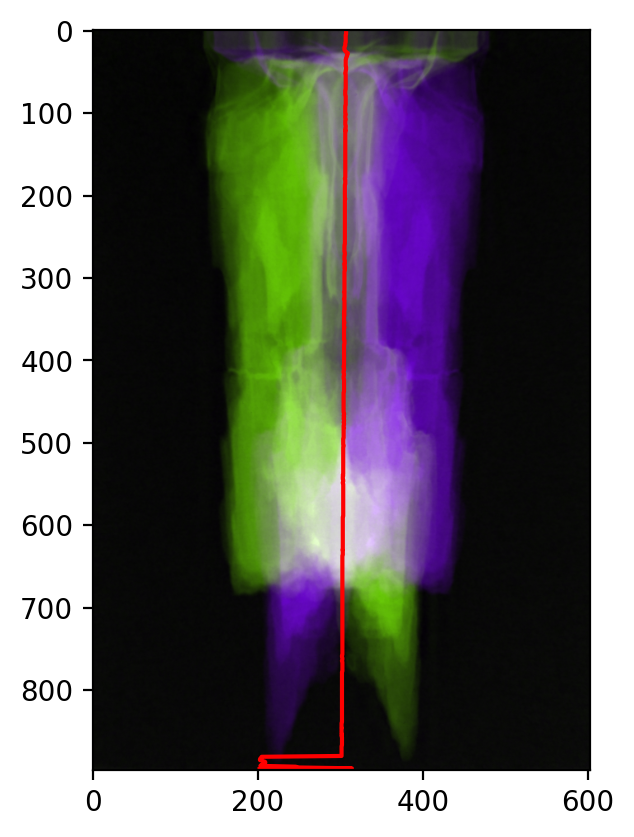

In [22]:
plt.imshow(rgb)
plt.plot(centers, np.arange(len(centers)), 'r')

## Reconstruction

In [23]:
reconstructor = pm.Reconstructor(pm.bpMultiProjParallel)

In [24]:
args = {"angles": np.linspace(0, 360, Nproj),
        "weights": np.ones(Nproj)}

In [25]:
reconstructor.configure({   "center" : center_estimate[0], 
                            "resolution" : 0.135
                        })

In [26]:
reconstructor.process(ring_cleaned_data, args)

604 897 626


In [27]:
vol = reconstructor.volume()

In [28]:
np.shape(vol)

(897, 604, 604)

In [30]:
io.save_TIFF('C:/Users/christianvedel/Imaging/reconstruction.tiff', vol)

  0%|          | 0/897 [00:00<?, ?it/s]

In [31]:
import tifffile as tiff

In [32]:
tiff.imwrite('C:/Users/christianvedel/Imaging/reconstruction.tiff', vol)